<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf backup/

In [2]:
!pip install yfinance

In [3]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [5]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [6]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [7]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,36995.177734,36899.671875,36484.290365,37005.434570,38016.343750,38793.988932,39414.640346,39896.602295,40161.264106,40327.414844,40512.142223,40863.904460,41328.347806,41733.225028,37037.379432,37003.899549,37254.861371,37639.899709,38060.480683,38480.322624,38887.721390,39279.731716,39656.626900,40019.796764,40370.846062,40711.196995,41041.941079,41363.820160,36967.163672,88.297985,73.741279,60.598852,90.435293,45.956740,59.106063,39.329044,24.483816,35.917191,23.869331,33.996246,21.803489,32.868982,25.859280,32.209263,29.814816,31.844184,33.950322,31.673026,35.484824,31.633276,31.344301,31.684540,26.844454,31.800009,25.299785,31.961532,28.733783,37399.803017,36590.552452,37303.517833,36495.825917,38025.658472,34942.922257,40248.471397,33762.397744,43157.982976,32874.704524,44706.644414,32881.333450,45702.580361,33126.700331,46334.754032,33458.450557,46409.870322,33912.657890,46326.124569,34328.705119,46362.964478,34661.319968,46980.115799,34747.693120,48054.898059,34601.797554,48865.957107,34600.492949
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,37461.283203,37182.172852,36943.304036,36643.423828,37557.213672,38349.860026,39034.971261,39511.304199,39936.990234,40129.934375,40267.751420,40525.852702,40960.621394,41428.863839,37535.347831,37316.072542,37406.138702,37671.995780,38010.271837,38373.247148,38740.602809,39103.802342,39459.543230,39806.895361,40145.931798,40477.047797,40800.636705,41116.958910,37321.027734,98.018923,100.000000,80.489905,92.361288,62.676847,96.555508,52.409849,33.177970,46.478115,27.719120,42.808736,26.400476,40.409137,26.753990,38.781145,26.821595,37.652369,36.915482,36.862002,37.417105,36.309357,34.614930,35.928602,29.927724,35.675263,27.927296,35.518470,31.774526,38375.003271,36547.563135,38019.248314,36345.097389,37955.819005,35930.789068,38239.493610,35047.354046,41689.710650,33424.716694,43611.369062,33088.350990,44997.915346,33072.027176,45645.370890,33377.237509,46222.930187,33651.050281,46193.378676,34066.490074,46104.082916,34431.419925,46371.690700,34680.014704,47356.019874,34565.222915,48478.925181,34378.802497
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,37961.255859,37478.216797,37253.533203,36853.531738,37196.598828,38007.162435,38675.027065,39232.967285,39681.563802,39941.263281,40112.309482,40299.568359,40640.623798,41087.841239,37937.235735,37644.915400,37615.293270,37775.592204,38033.527810,38337.082923,38660.279726,38990.199676,39320.452331,39647.970059,39971.344658,40289.938349,40603.417667,40911.525860,37703.430469,99.162285,100.000000,86.644272,92.659430,69.832950,95.066544,58.682490,67.735259,51.795701,32.015610,47.357905,30.929744,44.358457,28.481444,42.255739,31.889182,40.743358,34.535869,39.636887,38.111872,38.819380,39.461074,38.213601,35.109074,37.766867,30.307338,37.442249,28.641422,38461

# Create sequences

In [8]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1433, 90)

In [9]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
past_t = 100
forecast_t = 15
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1319, 100, 90)
Shape y --> (1319, 15)
Example of day -->


,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,53929.781250,55397.945312,53735.144531,54968.222656,3.249121e+10,54468.035156,54525.875977,53121.869792,51830.332520,50655.049609,49095.783529,48185.262277,47509.375977,47145.534505,46607.854883,46713.439986,46781.106608,46846.746094,46751.490792,54615.344020,53855.893687,52887.710478,51955.659116,51154.808932,50496.693471,49964.424094,49534.693549,49185.362337,48897.661526,48656.475005,48449.978484,48269.107420,48107.027201,54474.985156,87.682374,100.000000,80.768099,76.304322,80.801449,84.255153,80.285524,81.798045,79.084203,88.682024,77.547542,83.406860,75.919823,79.850777,74.333130,72.187538,72.850367,76.531251,71.496341,61.515509,70.275813,60.847004,69.183429,59.328027,68.209111,62.626700,67.340967,61.744258,55882.779049,53053.291264,56041.788354,53009.963599,57876.899075,48366.840508,58082.912463,45577.752576,58344.140307,42965.958912,59169.038087,39022.528970,58550.248424,37820.276130,57841.574558,37177.177395,57089.655036,37201.413975,56603.779550,36611.930216,56251.172955,37175.707017,55907.520062,37654.693154,55618.129712,38075.362476,55225.986834,38276.994751
1,54952.820312,56401.304688,54264.257812,54771.578125,3.952779e+10,54869.900391,54378.408203,54064.982422,52712.843750,51753.117969,50240.536458,49011.193638,48255.115234,47767.593967,47204.243750,47008.586115,47072.282389,47142.095553,47062.501814,54719.500090,54222.167462,53425.958377,52581.418896,51812.403331,51154.368033,50605.377965,50150.797617,49773.385051,49457.082155,49188.223102,48955.706455,48750.771916,48566.651403,54573.266016,61.749182,83.572153,72.843619,39.879878,76.355610,80.878211,77.231955,83.414822,76.781120,85.894420,75.713077,88.048176,74.404028,78.584371,73.046576,78.625499,71.735567,73.118016,70.514311,70.390651,69.399026,59.360880,68.391818,59.649731,67.487659,60.188182,66.678187,60.641729,55147.997754,54591.803028,55532.353712,53224.462694,56832.772637,51297.192206,58261.138839,47164.548661,58105.594348,45400.641590,59396.742333,41084.330583,59509.817048,38512.570229,58867.873203,37642.357266,58156.531317,37378.656617,57666.985693,36741.501807,57133.068433,36884.103797,56760.769542,37383.795237,56448.711469,37835.479637,56055.545081,38069.458546
2,54734.125000,57793.039062,54519.765625,57484.789062,4.263733e+10,56128.183594,55298.109375,55059.978516,53873.448242,52689.902734,51567.238607,50100.412109,49178.127441,48467.021267,48043.799414,47473.339311,47498.001953,47500.112530,47509.705915,56563.026072,55527.216102,54585.624287,53671.056710,52843.746191,52128.278960,51522.632778,51013.620140,50585.111789,50221.625670,49909.663621,49638.033064,49397.736149,49181.695379,55815.818359,97.111489,93.242120,91.660151,95.170923,88.537894,81.506510,86.404778,86.299931,84.428375,84.231771,82.473671,89.337762,80.577614,84.709712,78.787653,81.513803,77.131929,74.579816,75.620853,78.162388,74.253258,64.053318,73.021410,63.301391,71.914314,61.838102,70.919733,64.721429,59965.243299,52291.123888,58339.430294,52256.788456,57717.411234,52402.545797,58972.496902,48774.399582,59411.378032,45968.42

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1055, 100, 90)
Shape y_train --> (1055, 15)
Shape X_test  --> (264, 100, 90)
Shape y_test  --> (264, 15)
Example of day -->


,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,-0.975318,-0.975694,-0.974116,-0.975261,-0.961365,-0.975348,-0.975965,-0.978876,-0.980987,-0.981542,-0.982422,-0.984040,-0.985857,-0.986383,-0.986944,-0.987512,-0.987607,-0.987634,-0.987693,-0.975503,-0.976576,-0.978258,-0.980154,-0.982107,-0.984114,-0.984743,-0.985357,-0.985962,-0.986560,-0.987148,-0.987729,-0.988306,-0.988883,-0.975292,0.405856,-0.52700,0.518710,0.697073,0.525234,0.703968,0.499738,0.343625,0.466195,0.428503,0.436029,0.437886,0.414002,0.646230,0.396659,0.307942,0.380296,0.343132,0.361288,0.360578,0.344836,0.391126,0.330039,-0.006890,0.316205,-0.006877,0.302823,0.060781,-0.976789,-0.945868,-0.977372,-0.968504,-0.982504,-0.968950,-0.982683,-0.967625,-0.983321,-0.968242,-0.985100,-0.968822,-0.986824,-0.970003,-0.986977,-0.970930,-0.987626,-0.970833,-0.988633,-0.970987,-0.989838,-0.972291,-0.989062,-0.971250,-0.989149,-0.966126,-0.989280,-0.962484
1,-0.975233,-0.975369,-0.973651,-0.974058,-0.963101,-0.974630,-0.975088,-0.977995,-0.980316,-0.981190,-0.981983,-0.983627,-0.985392,-0.985991,-0.986575,-0.987224,-0.987707,-0.987482,-0.987544,-0.974614,-0.975814,-0.977555,-0.979507,-0.981508,-0.983555,-0.984217,-0.984857,-0.985483,-0.986098,-0.986701,-0.987295,-0.987884,-0.988471,-0.974599,0.889628,1.00000,0.758590,0.701196,0.698136,0.777773,0.645338,0.756258,0.595858,0.379831,0.553477,0.495855,0.520796,0.526710,0.494272,0.405326,0.469806,0.389573,0.443505,0.424792,0.420828,0.345985,0.400703,-0.124568,0.382283,0.081101,0.364931,0.067215,-0.974812,-0.946536,-0.977634,-0.966403,-0.981943,-0.967748,-0.981742,-0.967268,-0.982395,-0.968548,-0.984230,-0.968903,-0.985993,-0.970087,-0.986255,-0.970781,-0.986867,-0.970882,-0.987894,-0.971066,-0.989093,-0.972548,-0.989617,-0.970818,-0.988706,-0.966323,-0.988866,-0.962654
2,-0.974048,-0.975148,-0.973420,-0.973552,-0.958326,-0.973771,-0.974780,-0.977121,-0.979596,-0.980747,-0.981472,-0.983194,-0.984714,-0.985577,-0.986185,-0.986867,-0.987317,-0.987375,-0.987438,-0.973975,-0.975147,-0.976901,-0.978885,-0.980921,-0.982999,-0.983689,-0.984352,-0.984998,-0.985629,-0.986245,-0.986851,-0.987452,-0.988050,-0.974049,0.945596,1.00000,0.821835,0.451932,0.752825,0.776328,0.695311,0.769343,0.642644,0.474991,0.597346,0.569456,0.561695,0.540095,0.532354,0.692100,0.505216,0.404120,0.476378,0.441080,0.451466,0.443901,0.429381,0.448395,0.409245,0.047050,0.390383,0.034390,-0.974935,-0.944692,-0.976772,-0.966719,-0.981835,-0.966063,-0.981009,-0.966579,-0.981461,-0.968670,-0.983449,-0.968724,-0.985184,-0.970103,-0.986146,-0.969467,-0.986116,-0.970876,-0.987159,-0.971096,-0.988362,-0.972644,-0.988969,-0.970745,-0.988340,-0.966527,-0.988514,-0.962845
3,-0.973639,-0.974907,-0.974242,-0.975359,-0.954560,-0.974425,-0.974747,-0.976754,-0.979101,-0.980342,-0.981290,-0.982916,-0.984438,-0.985239,-0.985900,-0.986594,-0.987111,-0.987522,-0.987347,-0.974985,-0.975496,-0.976974,-0.978824,-0.980787,-0.982824,-0.983488,-0.984134,-0.984767,-0.985389,-0.985999,-0.986601,-0.987198,-0.987794,-0.974365,-0.697763,-0.56241,-0.285892,0.034037,-0.071098,0.295267,0.04

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [12]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [14]:
# Load Resnet model
image_shape = X_train.shape[1]

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image

inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 90)]         0         
                                                                 
 dense (Dense)               (None, 100, 100)          9100      
                                                                 
 reshape (Reshape)           (None, 100, 100, 1)       0         
                                                                 
 image_inp (Dense)           (None, 100, 100, 3)       6         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [15]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)

In [17]:
history = model.fit(X_train, y_train, epochs = 700, batch_size = 16, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/700
66/66 [==============================] - 27s 179ms/step - loss: 19843.4570 - mae: 19843.4570 - val_loss: 17069.2754 - val_mae: 17069.2754 - lr: 0.0100
Epoch 2/700
66/66 [==============================] - 8s 121ms/step - loss: 18353.4844 - mae: 18353.4844 - val_loss: 15344.6943 - val_mae: 15344.6943 - lr: 0.0100
Epoch 3/700
66/66 [==============================] - 8s 121ms/step - loss: 16577.3887 - mae: 16577.3887 - val_loss: 13691.2236 - val_mae: 13691.2236 - lr: 0.0100
Epoch 4/700
66/66 [==============================] - 8s 122ms/step - loss: 15181.5186 - mae: 15181.5186 - val_loss: 12465.8535 - val_mae: 12465.8535 - lr: 0.0100
Epoch 5/700
66/66 [==============================] - 9s 129ms/step - loss: 14094.4053 - mae: 14094.4053 - val_loss: 11759.4561 - val_mae: 11759.4561 - lr: 0.0100
Epoch 6/700
66/66 [==============================] - 8s 122ms/step - loss: 13358.7900 - mae: 13358.7900 - val_loss: 11091.5547 - val_mae: 11091.5547 - lr: 0.0100
Epoch 7/700
66/66 [========

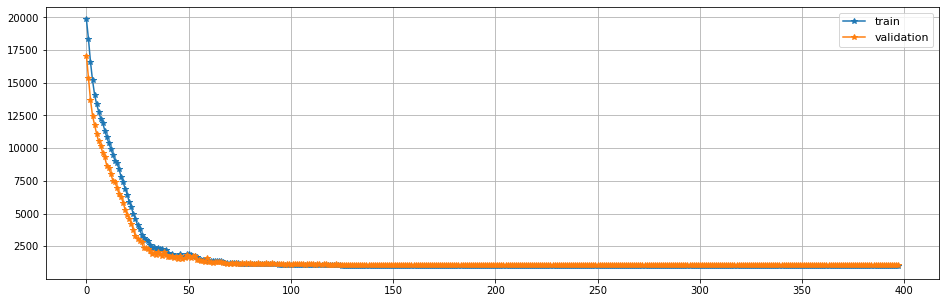

In [19]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [20]:
checkpoint = ModelCheckpoint('backup/modelo_best.h5', monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [21]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 100, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/50
66/66 [==============================] - 32s 266ms/step - loss: 1854.7178 - mae: 1854.7178 - val_loss: 1242.6868 - val_mae: 1242.6868
Epoch 2/50
66/66 [==============================] - 15s 221ms/step - loss: 1418.5140 - mae: 1418.5140 - val_loss: 1147.8738 - val_mae: 1147.8738
Epoch 3/50
66/66 [==============================] - 15s 222ms/step - loss: 1234.4597 - mae: 1234.4597 - val_loss: 1113.5127 - val_mae: 1113.5127
Epoch 4/50
66/66 [==============================] - 15s 223ms/step - loss: 1258.6656 - mae: 1258.6656 - val_loss: 950.7396 - val_mae: 950.7396
Epoch 5/50
66/66 [==============================] - 12s 174ms/step - loss: 1217.7338 - mae: 1217.7338 - val_loss: 1001.2977 - val_mae: 1001.2977
Epoch 6/50
66/66 [==============================] - 11s 174ms/step - loss: 1109.3987 - mae: 1109.3987 - val_loss: 983.9927 - val_mae: 983.9927
Epoch 7/50
66/66 [==============================] - 15s 227ms/step - loss: 1051.0514 - mae: 1051.0514 - val_loss: 876.0186 - val_mae: 

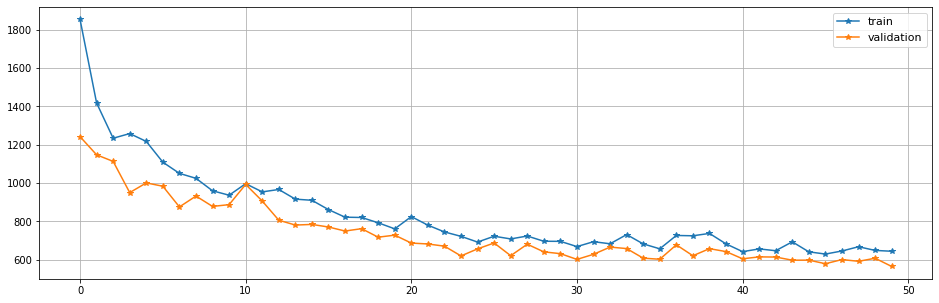

In [23]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [24]:
best_model = tf.keras.models.load_model('/content/backup/modelo_best.h5')
best_model.evaluate(X_test, y_test)

9/9 [==============================] - 6s 102ms/step - loss: 565.3874 - mae: 565.3874


[565.3873901367188, 565.3873901367188]

# Images created 

In [25]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

42/42 [==============================] - 0s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

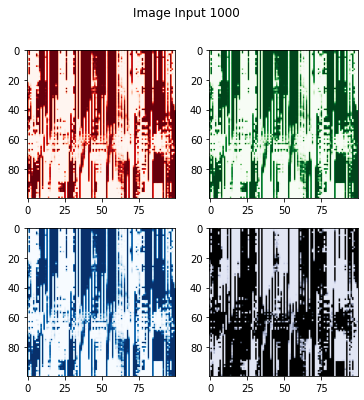

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


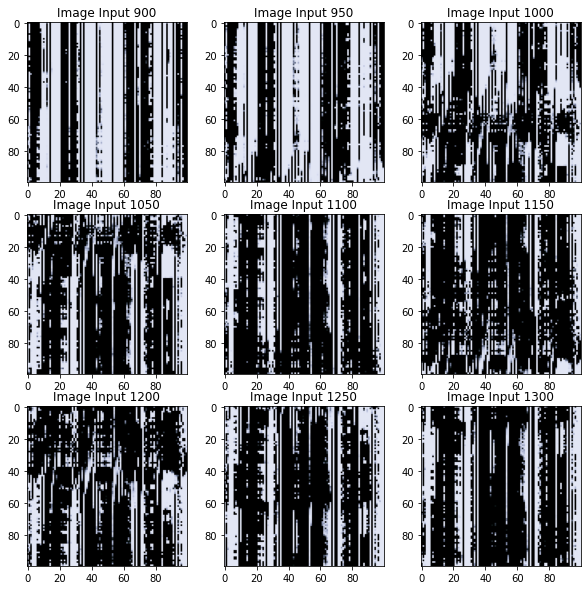

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,len(layer_output),50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

In [28]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

42/42 [==============================] - 4s 88ms/step


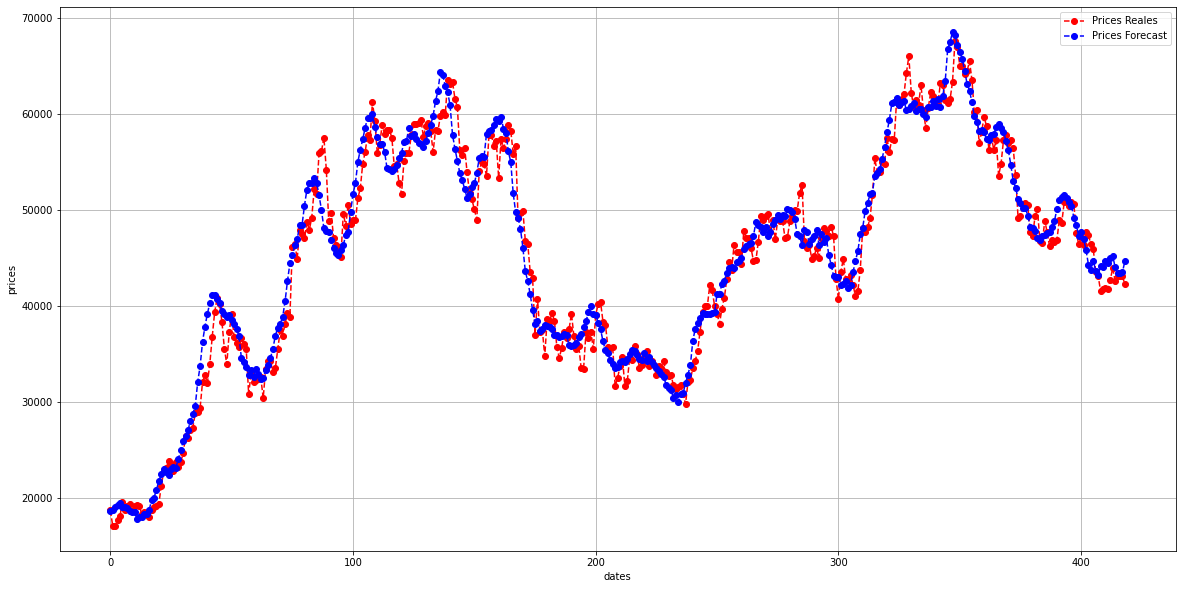

In [29]:
c = 900
day_pred = 0

fig=plt.figure(figsize=(20, 10))
plt.plot(y[c:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[c:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [30]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [31]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [32]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std    min     25%     50%      75%      max
0  264.0  1459.22  1660.97  77.17  364.27  629.69  2016.49  7274.75
Errores Full
    count     mean      std    min     25%     50%      75%      max
0  1319.0  1608.58  1729.84  64.05  399.48  669.34  2631.65  9430.11


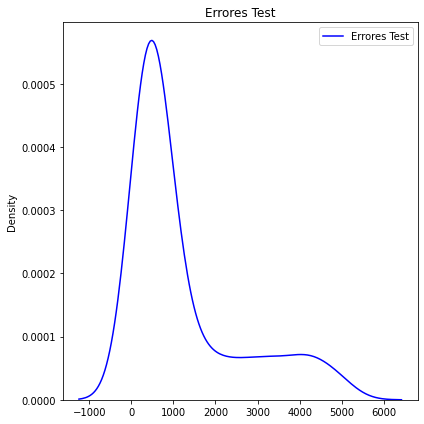

In [33]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

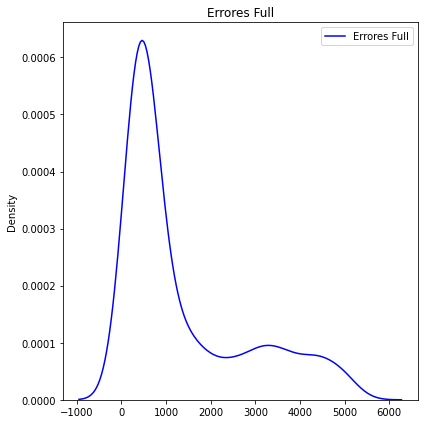

In [34]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [35]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

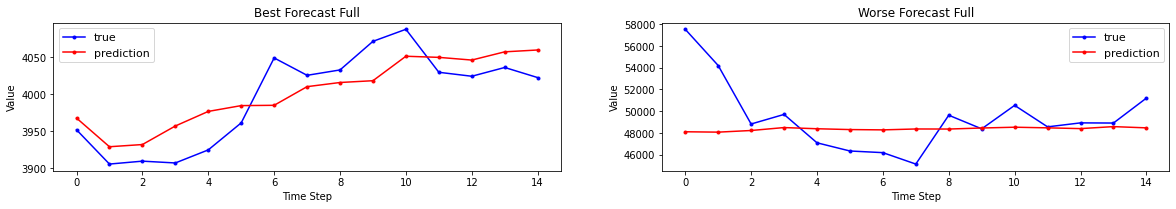

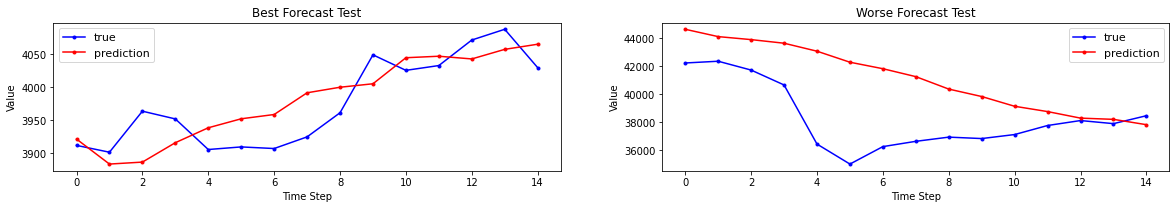

In [36]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();
